In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

In [2]:
df_train = pd.read_csv('train.csv', index_col=0)
display(df_train.head())

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df_original = df_train.copy()

## Feature Extraction

### Split Cabin column

In [4]:
# Add empty columns
df_train['Cabin_1'] = pd.Series([None]*len(df_train))
df_train['Cabin_2'] = pd.Series([None]*len(df_train))
df_train['Cabin_3'] = pd.Series([None]*len(df_train))

In [5]:
# Fill up empty columns
def cabin_split(row):
    if type(row['Cabin']) == float and np.isnan(row['Cabin']):
        return row
    split = row['Cabin'].split('/')
    #print(split)
    row['Cabin_1'] = split[0]
    row['Cabin_2'] = split[1]
    row['Cabin_3'] = split[2]
    return row
    
df_train = df_train.apply(cabin_split, axis=1)

### Get sex by name

In [6]:
# Load dataset with (name -> sex) relation (https://archive.ics.uci.edu/dataset/591/gender+by+name)
df_names = pd.read_csv('name_gender_dataset.csv', index_col='Name')
df_names = df_names.sort_values('Probability', ascending=False)
df_names = df_names[~df_names.index.duplicated(keep='first')]  # Remove all duplicates in index except the first one 
display(df_names.loc['John'])

# To get most probable sex for specific name
df_names.loc['John']['Gender']

Gender                M
Count           5260831
Probability    0.014398
Name: John, dtype: object

'M'

In [7]:
# Create empty column
df_train['Sex'] = pd.Series([None] * len(df_train))

In [8]:
# Get sex by name

# For performance
names_set = set(df_names.index)
names_to_sex_dict = df_names['Gender'].to_dict()

def sex_by_name(row):
    if pd.isna(row['Name']):
        return row
    name = row['Name'].split(' ')[0]
    if name in names_set:
        row['Sex'] = names_to_sex_dict[name]
    return row

df_train = df_train.apply(sex_by_name, axis=1)

In [9]:
df_train['Sex'].value_counts()

Sex
F    1930
M    1075
Name: count, dtype: int64

## Type Correction

In [10]:
# check types
df_train.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Cabin_1          object
Cabin_2          object
Cabin_3          object
Sex              object
dtype: object

In [11]:
df_train.nunique()

HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
Cabin_1            8
Cabin_2         1817
Cabin_3            2
Sex                2
dtype: int64

In [12]:
# unique values
df_train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'Cabin_1', 'Cabin_3', 'Sex']].apply(lambda x: x.unique())

HomePlanet                         [Europa, Earth, Mars, nan]
CryoSleep                                  [False, True, nan]
Destination    [TRAPPIST-1e, PSO J318.5-22, 55 Cancri e, nan]
VIP                                        [False, True, nan]
Transported                                     [False, True]
Cabin_1                         [B, F, A, G, nan, E, D, C, T]
Cabin_3                                           [P, S, nan]
Sex                                               [F, nan, M]
dtype: object

In [13]:
# transfrom CryoSleep, VIP and Transported to float64
display(df_train[['CryoSleep', 'VIP', 'Transported', 'Cabin_2']])
df_train['CryoSleep'] = df_train['CryoSleep'].astype('float64')
df_train['VIP'] = df_train['VIP'].astype('float64')
df_train['Transported'] = df_train['Transported'].astype('float64')
df_train['Cabin_2'] = df_train['Cabin_2'].astype('float64')
display(df_train[['CryoSleep', 'VIP', 'Transported', 'Cabin_2']])

,CryoSleep,VIP,Transported,Cabin_2
PassengerId,,,,
0001_01,False,False,False,0
0002_01,False,False,True,0
0003_01,False,True,False,0
0003_02,False,False,False,0
0004_01,False,False,True,1
...,...,...,...,...
9276_01,False,True,False,98
9278_01,True,False,False,1499
9279_01,False,False,True,1500


,CryoSleep,VIP,Transported,Cabin_2
PassengerId,,,,
0001_01,0.0,0.0,0.0,0.0
0002_01,0.0,0.0,1.0,0.0
0003_01,0.0,1.0,0.0,0.0
0003_02,0.0,0.0,0.0,0.0
0004_01,0.0,0.0,1.0,1.0
...,...,...,...,...
9276_01,0.0,1.0,0.0,98.0
9278_01,1.0,0.0,0.0,1499.0
9279_01,0.0,0.0,1.0,1500.0


## Pick out categorical and numerical columns

In [14]:
# Drop out unnecessary columns
to_drop = ['Name', 'Cabin']
df_train.drop(to_drop, axis=1, inplace=True)

In [15]:
df_train.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Transported        2
Cabin_1            8
Cabin_2         1817
Cabin_3            2
Sex                2
dtype: int64

In [16]:
# categorical columns
cat_columns = df_train.columns[df_train.nunique() < 10]
display(df_train[cat_columns])
display(df_train[cat_columns].nunique())
display(df_train['HomePlanet'].value_counts())
display(df_train['Destination'].value_counts())
display(df_train['Cabin_1'].value_counts())
display(df_train['Cabin_3'].value_counts())
display(df_train['Sex'].value_counts())

,HomePlanet,CryoSleep,Destination,VIP,Transported,Cabin_1,Cabin_3,Sex
PassengerId,,,,,,,,
0001_01,Europa,0.0,TRAPPIST-1e,0.0,0.0,B,P,F
0002_01,Earth,0.0,TRAPPIST-1e,0.0,1.0,F,S,F
0003_01,Europa,0.0,TRAPPIST-1e,1.0,0.0,A,S,NaN
0003_02,Europa,0.0,TRAPPIST-1e,0.0,0.0,A,S,NaN
0004_01,Earth,0.0,TRAPPIST-1e,0.0,1.0,F,S,M
...,...,...,...,...,...,...,...,...
9276_01,Europa,0.0,55 Cancri e,1.0,0.0,A,P,NaN
9278_01,Earth,1.0,PSO J318.5-22,0.0,0.0,G,S,M
9279_01,Earth,0.0,TRAPPIST-1e,0.0,1.0,G,S,NaN


HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
Transported    2
Cabin_1        8
Cabin_3        2
Sex            2
dtype: int64

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

Cabin_1
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

Cabin_3
S    4288
P    4206
Name: count, dtype: int64

Sex
F    1930
M    1075
Name: count, dtype: int64

In [17]:
num_columns = df_train.columns[df_train.nunique() > 10]
df_train[num_columns]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_2
PassengerId,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,0.0
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,1.0
...,...,...,...,...,...,...,...
9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,98.0
9278_01,18.0,0.0,0.0,0.0,0.0,0.0,1499.0
9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,1500.0


## Manual correlation analysis

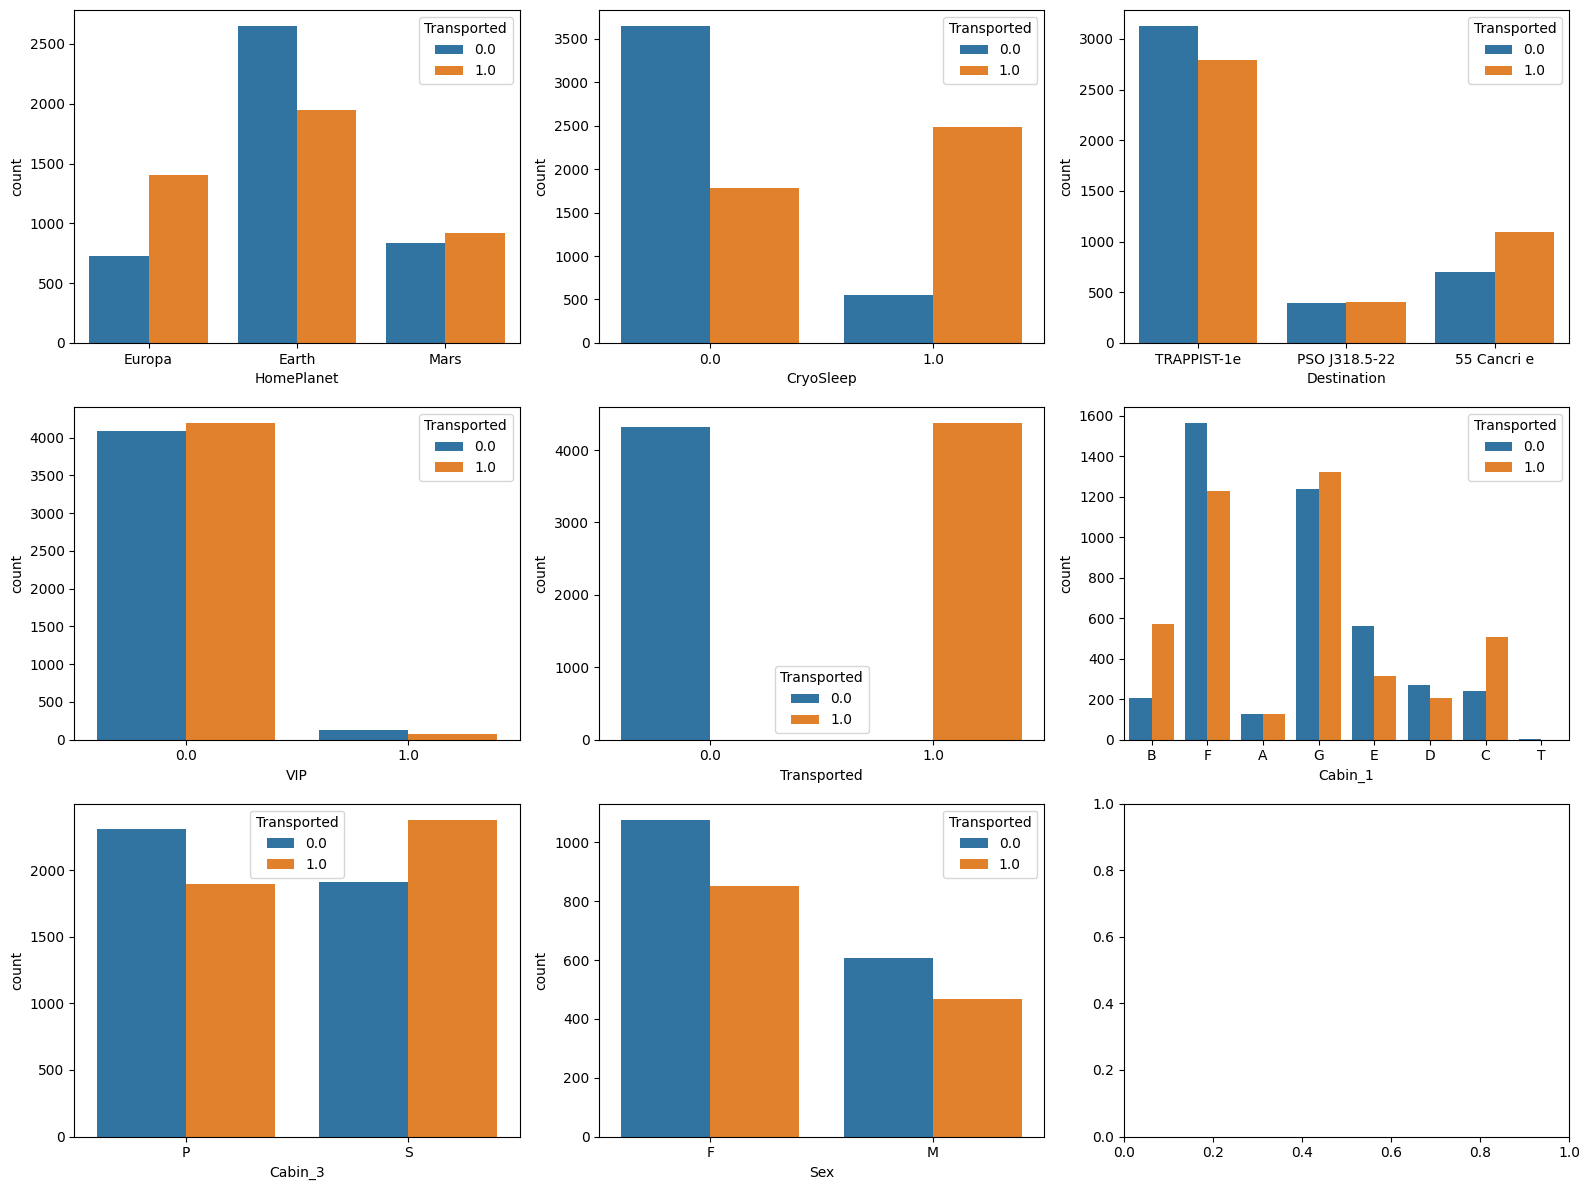

In [18]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(12)
fig.set_figwidth(16)
axs = axs.ravel()
for i, c in enumerate(cat_columns):
    sns.countplot(ax=axs[i], data=df_train, x=c, hue='Transported')
plt.tight_layout()
plt.show()

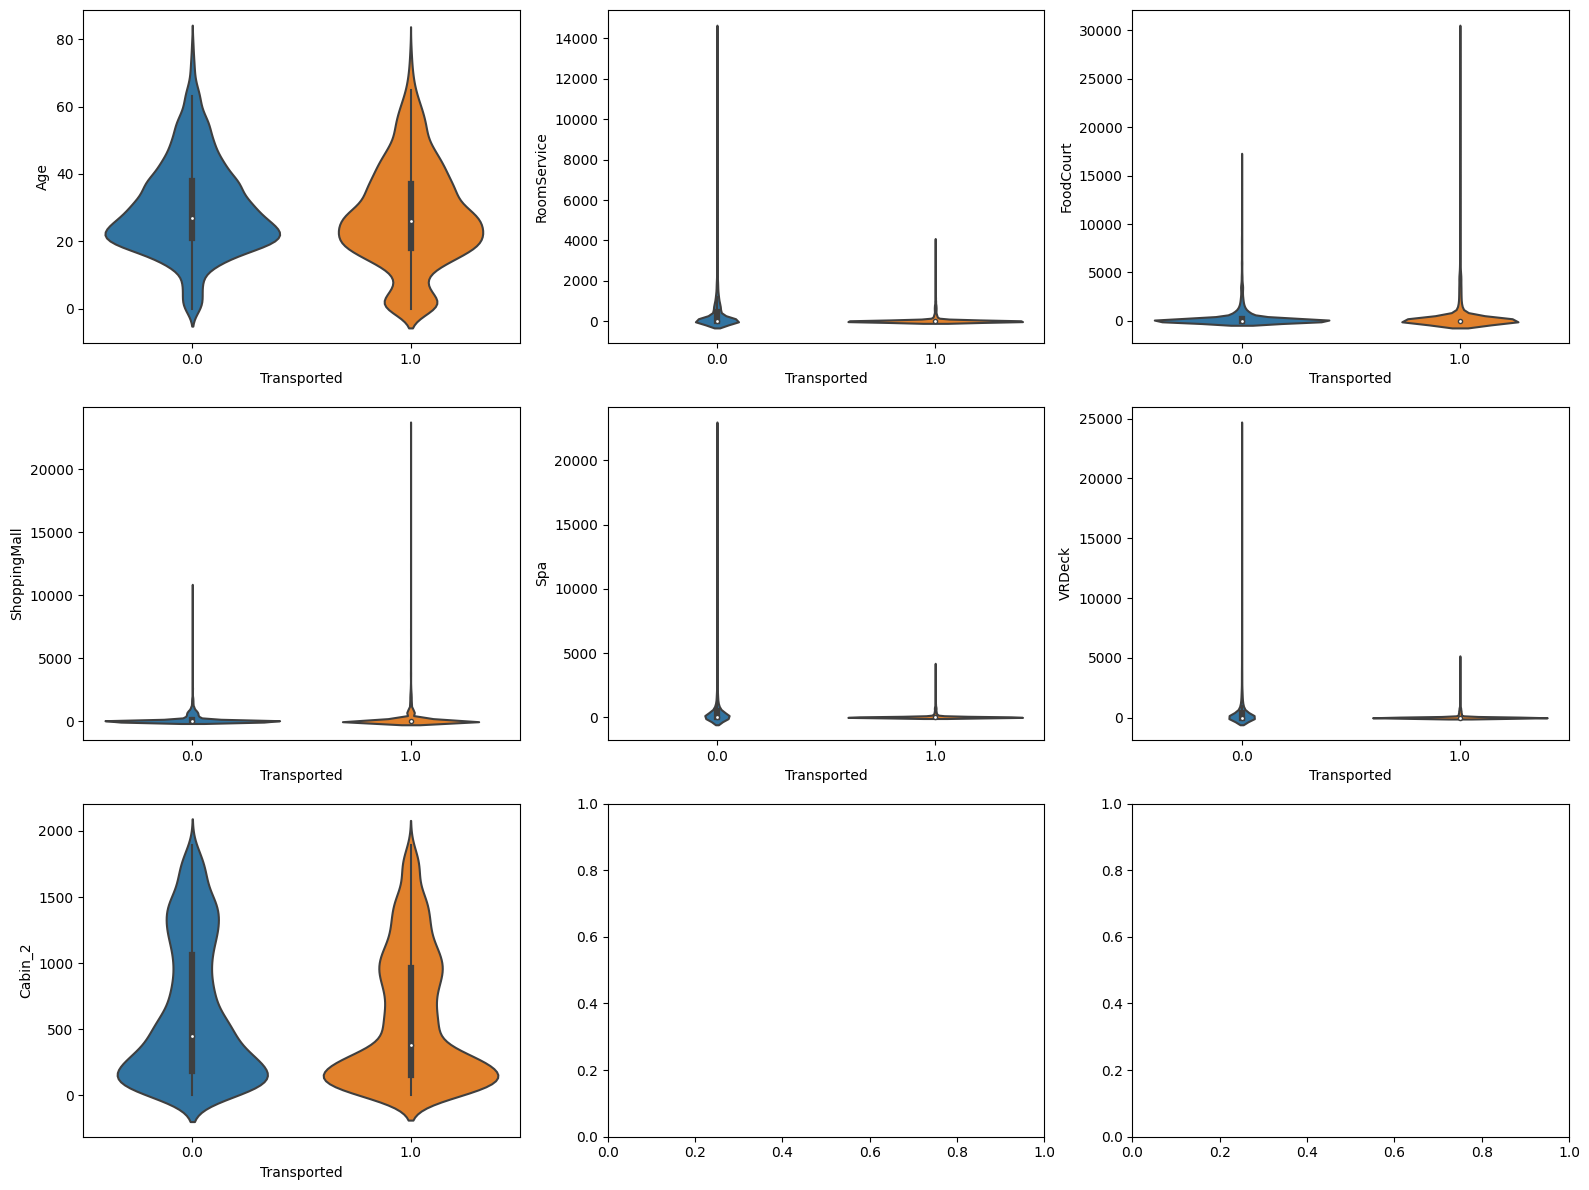

In [19]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(12)
fig.set_figwidth(16)
axs = axs.ravel()
for i, c in enumerate(num_columns):
    sns.violinplot(ax=axs[i], data=df_train, y=c, x='Transported')
plt.tight_layout()
plt.show()

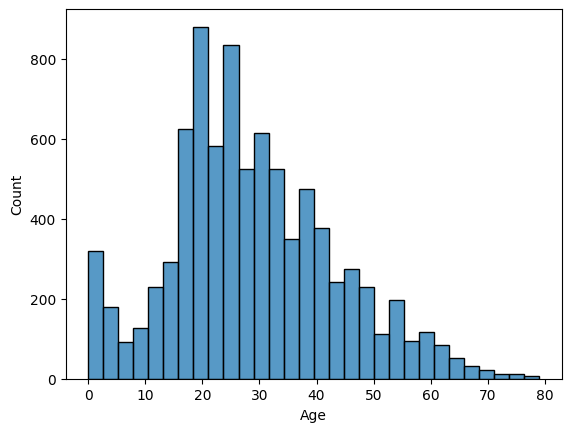

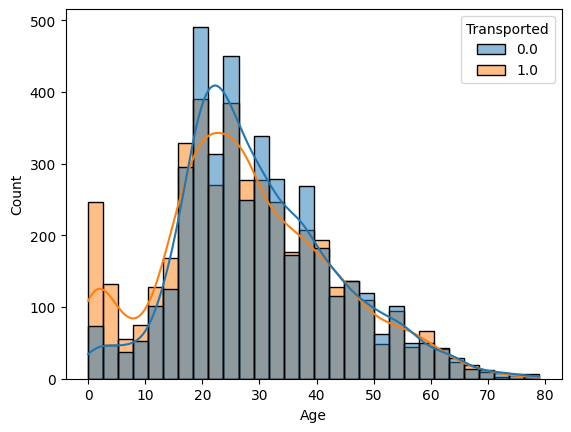

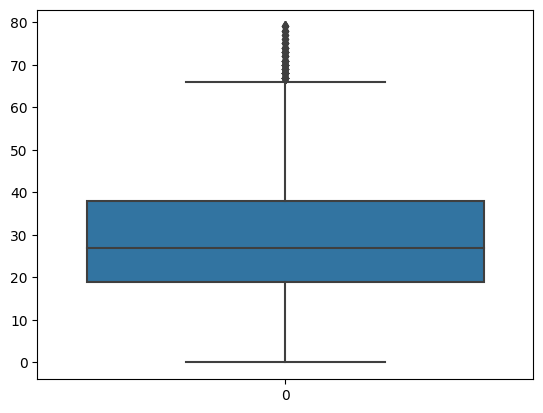

28.82793046746535

27.0

In [20]:
# Check distribution for every column
col = 'Age'
sns.histplot(df_train[col], bins=30)
plt.show()
sns.histplot(x=df_train[col], hue=df_train['Transported'], kde=True, bins=30)
plt.show()
sns.boxplot(df_train[col])
plt.show()
display(df_train[col].mean())
display(df_train[col].median())

20.0 38.0 18.0
27.0
81.0


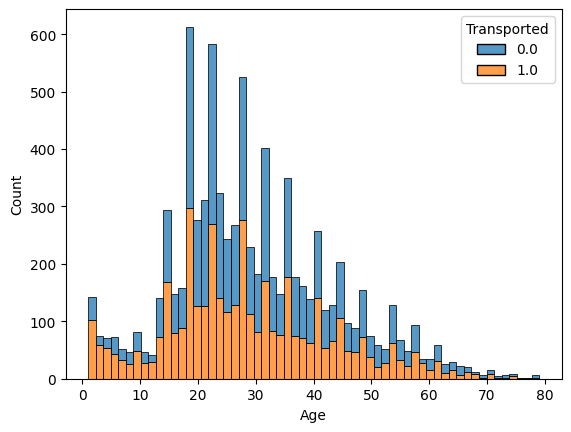

In [21]:
# get col without zero values and with IQR filtering
test = df_train[df_train[col] > 0][col]
Q1 = np.percentile(test, 25)
Q3 = np.percentile(test, 75)
IQR = Q3-Q1
print(Q1, Q3, IQR)
print(test.median())
print(test.median() + 3*IQR)
test_iqr = test[test <= test.median() + 3*IQR]
test_iqr_with_target = pd.concat([test_iqr, df_train.loc[test_iqr.index]['Transported']], axis=1)
sns.histplot(x=col, hue='Transported', multiple='stack', data=test_iqr_with_target, kde=False, bins=60)
plt.show()

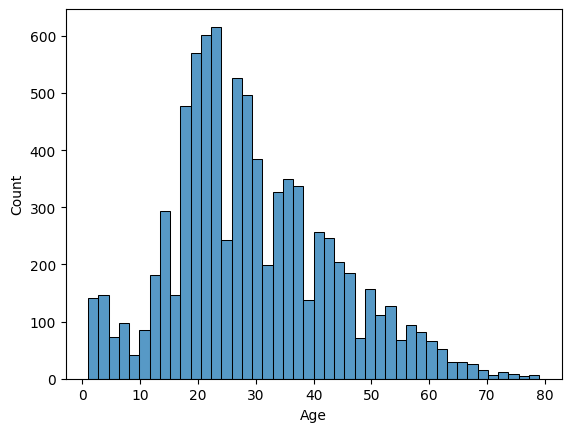

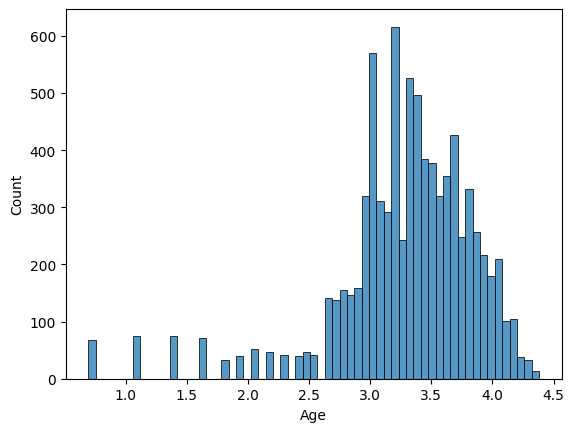

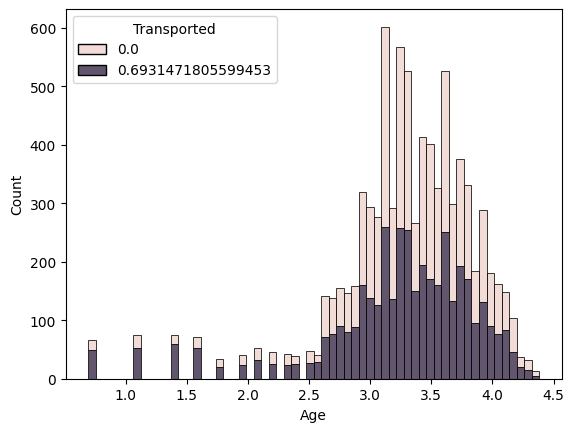

In [22]:
sns.histplot(test)
plt.show()
sns.histplot(np.log1p(test))
plt.show()
sns.histplot(x=col, hue='Transported', multiple='stack', data=np.log1p(test_iqr_with_target), kde=False, bins=60)
plt.show()

## Binning

In [23]:
# # return min_IQR_limit and max_IQR_limit
# def get_IQR(df, coef=3):  
#     Q1 = np.percentile(df, 25)
#     Q3 = np.percentile(df, 75)
#     IQR = Q3-Q1
#     return df.median() - coef*IQR, test.median() + coef*IQR

In [24]:
# # binning into 3 categories: zero values, fits in IQR, outliers
# def _binning(row, max_IQR):
#     if row == 0:
#         return 0
#     elif row <= max_IQR:
#         return 1
#     else:
#         return 2

# binning_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# for col in binning_cols:
#     df_train[col] = df_train[col].apply(_binning, max_IQR=get_IQR(df_train[df_train[col] > 0][col])[1])
#     print(df_train[col].value_counts())

## Label encoding

In [25]:
df_train['Sex'].unique()

array(['F', nan, 'M'], dtype=object)

In [26]:
#df_train['HomePlanet'] = df_train['HomePlanet'].map({'Earth':0, 'Europa':1, 'Mars':2}).astype('float')
#df_train['Destination'] = df_train['Destination'].map({'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2}).astype('float')
df_train['Cabin_1'] = df_train['Cabin_1'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7}).astype('float')
df_train['Cabin_3'] = df_train['Cabin_3'].map({'P':0, 'S':1}).astype('float')
df_train['Sex'] = df_train['Sex'].map({'F':0, 'M':1}).astype('float')

In [27]:
df_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_1,Cabin_2,Cabin_3,Sex
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,5.0,0.0,1.0,0.0
0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,0.0,1.0,NaN
0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,0.0,1.0,NaN
0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,5.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,0.0,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0.0,98.0,0.0,NaN
9278_01,Earth,1.0,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1499.0,1.0,1.0
9279_01,Earth,0.0,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1.0,6.0,1500.0,1.0,NaN


## Missing values columns

In [28]:
# check for None
df_train.isnull().sum()

HomePlanet       201
CryoSleep        217
Destination      182
Age              179
VIP              203
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Transported        0
Cabin_1          199
Cabin_2          199
Cabin_3          199
Sex             5688
dtype: int64

In [29]:
# create duplicates for missing columns
df_missing = df_original.isnull().drop(['Transported'], axis=1).astype('float')
df_missing.columns = [f'miss_{c}' for c in df_original.columns[:-1]]
df_missing = pd.concat([df_train, df_missing], axis=1)
display(df_missing)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,miss_Cabin,miss_Destination,miss_Age,miss_VIP,miss_RoomService,miss_FoodCourt,miss_ShoppingMall,miss_Spa,miss_VRDeck,miss_Name
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,0.0,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9278_01,Earth,1.0,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9279_01,Earth,0.0,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Handling missing values
df_train['HomePlanet'].fillna(df_train['HomePlanet'].mode()[0], inplace=True)
df_train['CryoSleep'].fillna(method='ffill', inplace=True)
df_train['Destination'].fillna(df_train['Destination'].mode()[0], inplace=True)
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_train['VIP'].fillna(df_train['VIP'].mode()[0], inplace=True)
df_train['RoomService'].fillna(df_train['RoomService'].median(), inplace=True)
df_train['FoodCourt'].fillna(df_train['FoodCourt'].median(), inplace=True)
df_train['ShoppingMall'].fillna(df_train['ShoppingMall'].median(), inplace=True)
df_train['Spa'].fillna(df_train['Spa'].median(), inplace=True)
df_train['VRDeck'].fillna(df_train['VRDeck'].median(), inplace=True)
df_train['Cabin_1'].fillna(df_train['Cabin_1'].mode()[0], inplace=True)
df_train['Cabin_2'].fillna(df_train['Cabin_2'].mean(), inplace=True)
df_train['Cabin_3'].fillna(df_train['Cabin_3'].mode()[0], inplace=True)
df_train['Sex'].fillna(method='ffill', inplace=True)

In [31]:
df_train.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Cabin_1         0
Cabin_2         0
Cabin_3         0
Sex             0
dtype: int64

## OneHotEncoding

In [32]:
df_train.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               81
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Transported        2
Cabin_1            8
Cabin_2         1818
Cabin_3            2
Sex                2
dtype: int64

In [33]:
from sklearn.preprocessing import OneHotEncoder

to_onehot = ['HomePlanet', 'Destination'] 

for col in to_onehot:
    # fit
    encoder = OneHotEncoder(sparse_output=False).fit(df_train[[col]])  # encoder
    print(encoder.categories_)
    # transform
    nunique = df_train[[col]].nunique().item()  # number of unique values
    new_cols = pd.DataFrame(encoder.transform(df_train[[col]]), 
                            columns=[f'{col}_{n}' for n in range(nunique)], index=df_train.index)
    # add to df
    df_train = pd.concat([df_train, new_cols], axis=1)
    
df_train = df_train.drop(to_onehot, axis=1)
df_missing = df_missing.drop(to_onehot, axis=1)
display(df_train.columns)

[array(['Earth', 'Europa', 'Mars'], dtype=object)]
[array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object)]


Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Cabin_1', 'Cabin_2', 'Cabin_3', 'Sex',
       'HomePlanet_0', 'HomePlanet_1', 'HomePlanet_2', 'Destination_0',
       'Destination_1', 'Destination_2'],
      dtype='object')

## Aggregation

In [34]:
df_train.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Cabin_1', 'Cabin_2', 'Cabin_3', 'Sex',
       'HomePlanet_0', 'HomePlanet_1', 'HomePlanet_2', 'Destination_0',
       'Destination_1', 'Destination_2'],
      dtype='object')

In [35]:
# combine columns by sum
agg_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def _multiply_features(row):
    for c1 in range(len(agg_columns)):
        for c2 in range(c1):
            row[f'{agg_columns[c1]}_{agg_columns[c2]}'] = row[agg_columns[c1]] + row[agg_columns[c2]]
    return row

x = df_train.copy()
for c1 in range(len(agg_columns)):
    for c2 in range(c1):
        x[f'{agg_columns[c1]}_{agg_columns[c2]}'] = \
            pd.Series({f'{agg_columns[c1]}_{agg_columns[c2]}':[None for _ in range(len(x))]})
x = x.apply(_multiply_features, axis=1)
x

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_1,...,FoodCourt_RoomService,ShoppingMall_RoomService,ShoppingMall_FoodCourt,Spa_RoomService,Spa_FoodCourt,Spa_ShoppingMall,VRDeck_RoomService,VRDeck_FoodCourt,VRDeck_ShoppingMall,VRDeck_Spa
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,5.0,...,118.0,134.0,34.0,658.0,558.0,574.0,153.0,53.0,69.0,593.0
0003_01,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,...,3619.0,43.0,3576.0,6758.0,10291.0,6715.0,92.0,3625.0,49.0,6764.0
0003_02,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,...,1283.0,371.0,1654.0,3329.0,4612.0,3700.0,193.0,1476.0,564.0,3522.0
0004_01,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,5.0,...,373.0,454.0,221.0,868.0,635.0,716.0,305.0,72.0,153.0,567.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0.0,...,6819.0,0.0,6819.0,1643.0,8462.0,1643.0,74.0,6893.0,74.0,1717.0
9278_01,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9279_01,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1.0,6.0,...,0.0,1872.0,1872.0,1.0,1.0,1873.0,0.0,0.0,1872.0,1.0


In [36]:
# # combine columns by multipication
# mul_columns = ['']
# agg_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# def _multiply_features(row):
#     for c1 in range(len(agg_columns)):
#         for c2 in range(c1):
#             row[f'{agg_columns[c1]}_{agg_columns[c2]}'] = row[agg_columns[c1]] + row[agg_columns[c2]]
#     return row

# x = df_train.copy()
# for c1 in range(len(agg_columns)):
#     for c2 in range(c1):
#         x[f'{agg_columns[c1]}_{agg_columns[c2]}'] = \
#             pd.Series({f'{agg_columns[c1]}_{agg_columns[c2]}':[None for _ in range(len(x))]})
# x = x.apply(_multiply_features, axis=1)
# x

<Axes: xlabel='Spa_FoodCourt', ylabel='Count'>

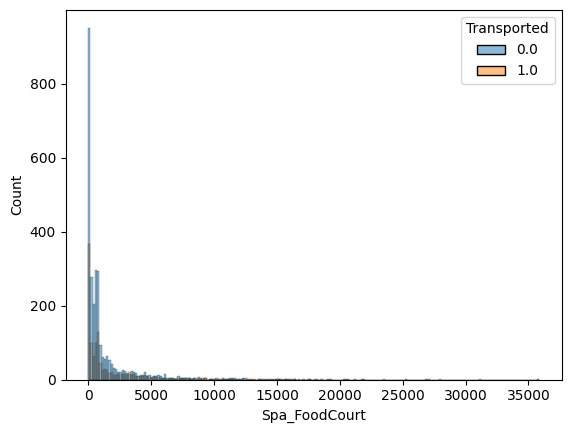

In [37]:
sns.histplot(data=x[x['Spa_FoodCourt'] > 0], x='Spa_FoodCourt', hue='Transported')

In [38]:
df_train = x

## Correlation check

In [39]:
for c in df_train.columns:
    df_missing[c] = df_train[c]

In [40]:
# classic correlation
pearson_corr = df_missing.corr(method='pearson')
kendall_corr = df_missing.corr(method='kendall')

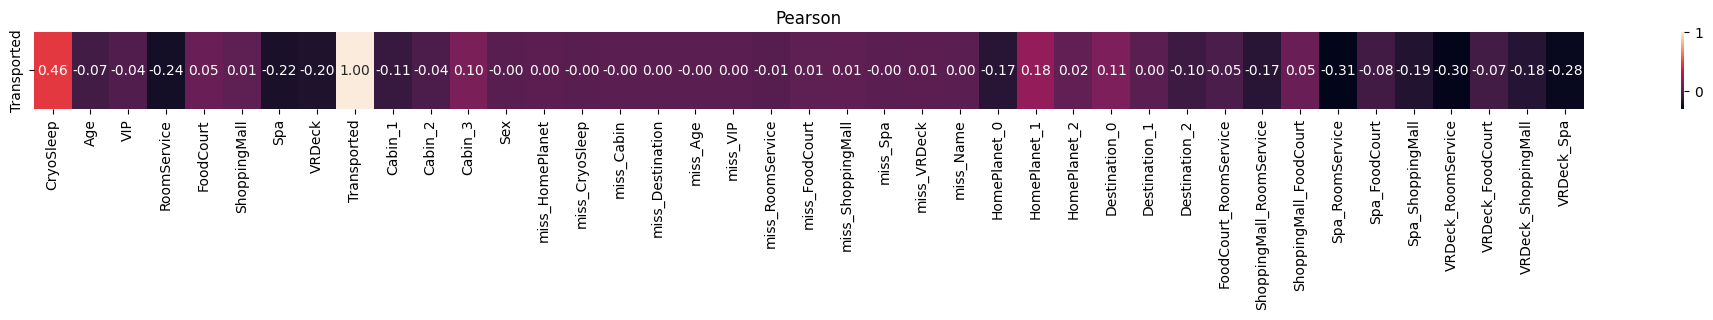

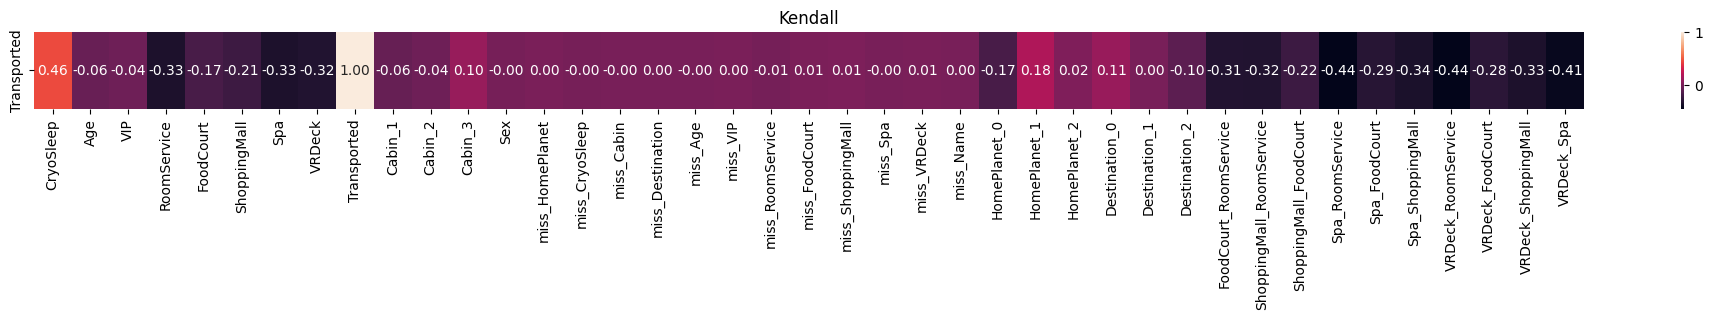

Transported                 1.000000
CryoSleep                   0.456062
Spa_RoomService            -0.309279
VRDeck_RoomService         -0.300834
VRDeck_Spa                 -0.279443
RoomService                -0.241124
Spa                        -0.218545
VRDeck                     -0.204874
Spa_ShoppingMall           -0.187464
VRDeck_ShoppingMall        -0.177419
HomePlanet_1                0.176916
HomePlanet_0               -0.168845
ShoppingMall_RoomService   -0.168123
Cabin_1                    -0.114941
Destination_0               0.108722
Cabin_3                     0.101397
Name: Transported, dtype: float64
Transported                 1.000000
CryoSleep                   0.456062
Spa_RoomService            -0.443965
VRDeck_RoomService         -0.439028
VRDeck_Spa                 -0.410517
Spa_ShoppingMall           -0.339059
VRDeck_ShoppingMall        -0.334991
RoomService                -0.334189
Spa                        -0.333830
VRDeck                     -0.318010
Shop

In [41]:
plt.figure(figsize=(25,1))
plt.title('Pearson')
sns.heatmap(pearson_corr[['Transported']].T, annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(25,1))
plt.title('Kendall')
sns.heatmap(kendall_corr[['Transported']].T, annot=True, fmt='.2f')
plt.show()

print(pearson_corr[pearson_corr['Transported'].abs() > 0.1]['Transported'].sort_values(ascending=False, key=abs))
print(kendall_corr[kendall_corr['Transported'].abs() > 0.1]['Transported'].sort_values(ascending=False, key=abs))

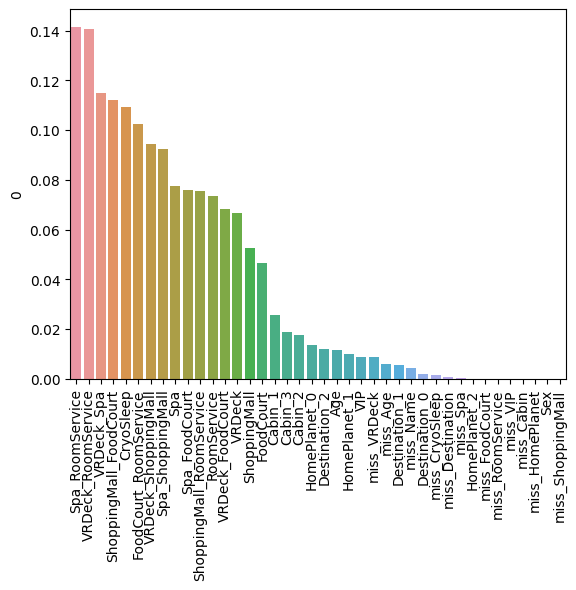

In [42]:
# mutual information
mutual_info = mutual_info_classif(
    X = df_missing.drop(['Transported'], axis=1),
    y = df_missing['Transported'],
#    discrete_features = ['CryoSleep', 'VIP', 'HomePlanet', 'Destination', *[c for c in df_missing.columns if c[:5] == 'miss_']],
)

# reformat mutual info into df
indices = [*df_missing.columns]
indices.remove('Transported')
mi_df = pd.DataFrame(mutual_info, index=indices).sort_values(0, ascending=False)

# show
plt.xticks(rotation=90)
sns.barplot(x=mi_df.index, y=mi_df[0])
plt.show()

ROC-AUC: 0.8641031417732254


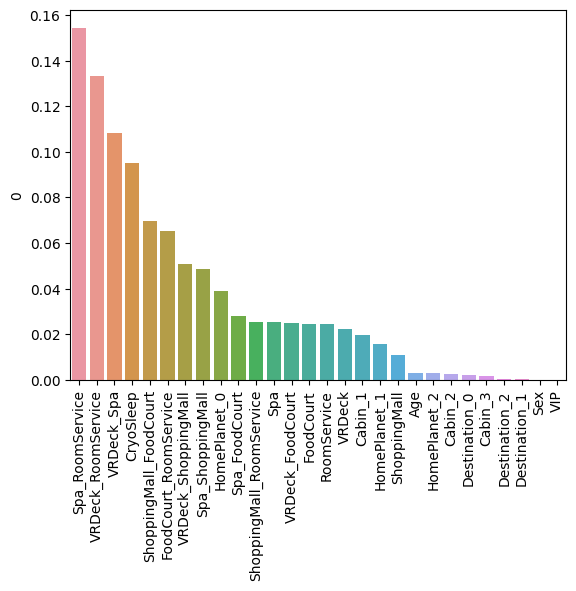

In [43]:
# random forest feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(n_estimators=100, max_depth=4)
scores = cross_val_score(model, df_train.drop('Transported', axis=1), df_train['Transported'], cv=5, scoring='roc_auc')
model.fit(df_train.drop('Transported', axis=1), df_train['Transported'])
fe_df = pd.DataFrame(model.feature_importances_, index=df_train.drop('Transported', axis=1).columns).sort_values(0, ascending=False)

# show
print('ROC-AUC:', scores.mean())
plt.xticks(rotation=90)
sns.barplot(x=fe_df.index, y=fe_df[0])
plt.show()

In [44]:
high_corr_columns = ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'ShoppingMall', 'Spa_VRDeck'] 
medium_corr_columns = ['FoodCourt', 'HomePlanet_0', 'HomePlanet_1', 'Cabin_1', 'Cabin_3', 'Age', 'Cabin_2', 'miss_Spa', 
                      'miss_ShoppingMall', 'miss_CryoSleep', 'miss_Age']
no_corr_columns = list(mi_df[mi_df.iloc[:,0] < 0.0001].index)
to_remove = high_corr_columns + medium_corr_columns + no_corr_columns + ['Transported']
low_corr_columns = [c for c in df_missing if c not in to_remove]

print('High:\n', high_corr_columns)
print('Medium:\n', medium_corr_columns)
print('Low:\n', low_corr_columns)
print('No:\n', no_corr_columns)

High:
 ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'ShoppingMall', 'Spa_VRDeck']
Medium:
 ['FoodCourt', 'HomePlanet_0', 'HomePlanet_1', 'Cabin_1', 'Cabin_3', 'Age', 'Cabin_2', 'miss_Spa', 'miss_ShoppingMall', 'miss_CryoSleep', 'miss_Age']
Low:
 ['VIP', 'miss_Destination', 'miss_VRDeck', 'miss_Name', 'Destination_0', 'Destination_1', 'Destination_2', 'FoodCourt_RoomService', 'ShoppingMall_RoomService', 'ShoppingMall_FoodCourt', 'Spa_RoomService', 'Spa_FoodCourt', 'Spa_ShoppingMall', 'VRDeck_RoomService', 'VRDeck_FoodCourt', 'VRDeck_ShoppingMall', 'VRDeck_Spa']
No:
 ['HomePlanet_2', 'miss_FoodCourt', 'miss_RoomService', 'miss_VIP', 'miss_Cabin', 'miss_HomePlanet', 'Sex', 'miss_ShoppingMall']


> **Note**
>
> - Columns with **high** correlation with target are:
>   - 'CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'ShoppingMall'
> - Columns with **medium** correlation with target are:
>   - 'FoodCourt', 'HomePlanet_0', 'HomePlanet_1', 'Cabin_1', 'Cabin_3', 'Age', 'Cabin_2', 'miss_Spa', 'miss_ShoppingMall', 'miss_CryoSleep', 'miss_Age'
> - Columns with **low** correlation with target are:
>   - 'VIP', 'Sex', 'miss_VRDeck', 'miss_Name', 'Destination_1', 'Destination_2'

## Select columns

In [92]:
selected_columns = list(fe_df.head(20).index) + [x for x in mi_df.index if x[:5] == 'miss_'][:6] # high_corr_columns + medium_corr_columns #+ low_corr_columns
df_train = df_missing[selected_columns + ['Transported']]
df_train

,Spa_RoomService,VRDeck_RoomService,VRDeck_Spa,CryoSleep,ShoppingMall_FoodCourt,FoodCourt_RoomService,VRDeck_ShoppingMall,Spa_ShoppingMall,HomePlanet_0,Spa_FoodCourt,...,HomePlanet_1,ShoppingMall,Age,miss_VRDeck,miss_Age,miss_Name,miss_CryoSleep,miss_Destination,miss_Spa,Transported
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,658.0,153.0,593.0,0.0,34.0,118.0,69.0,574.0,1.0,558.0,...,0.0,25.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0003_01,6758.0,92.0,6764.0,0.0,3576.0,3619.0,49.0,6715.0,0.0,10291.0,...,1.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003_02,3329.0,193.0,3522.0,0.0,1654.0,1283.0,564.0,3700.0,0.0,4612.0,...,1.0,371.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0004_01,868.0,305.0,567.0,0.0,221.0,373.0,153.0,716.0,1.0,635.0,...,0.0,151.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,1643.0,74.0,1717.0,0.0,6819.0,6819.0,74.0,1643.0,0.0,8462.0,...,1.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9278_01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9279_01,1.0,0.0,1.0,0.0,1872.0,0.0,1872.0,1873.0,1.0,1.0,...,0.0,1872.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Check correlation between features

In [93]:
pearson = df_train.drop('Transported', axis=1).corr(method='pearson')
kendall = df_train.drop('Transported', axis=1).corr(method='kendall')

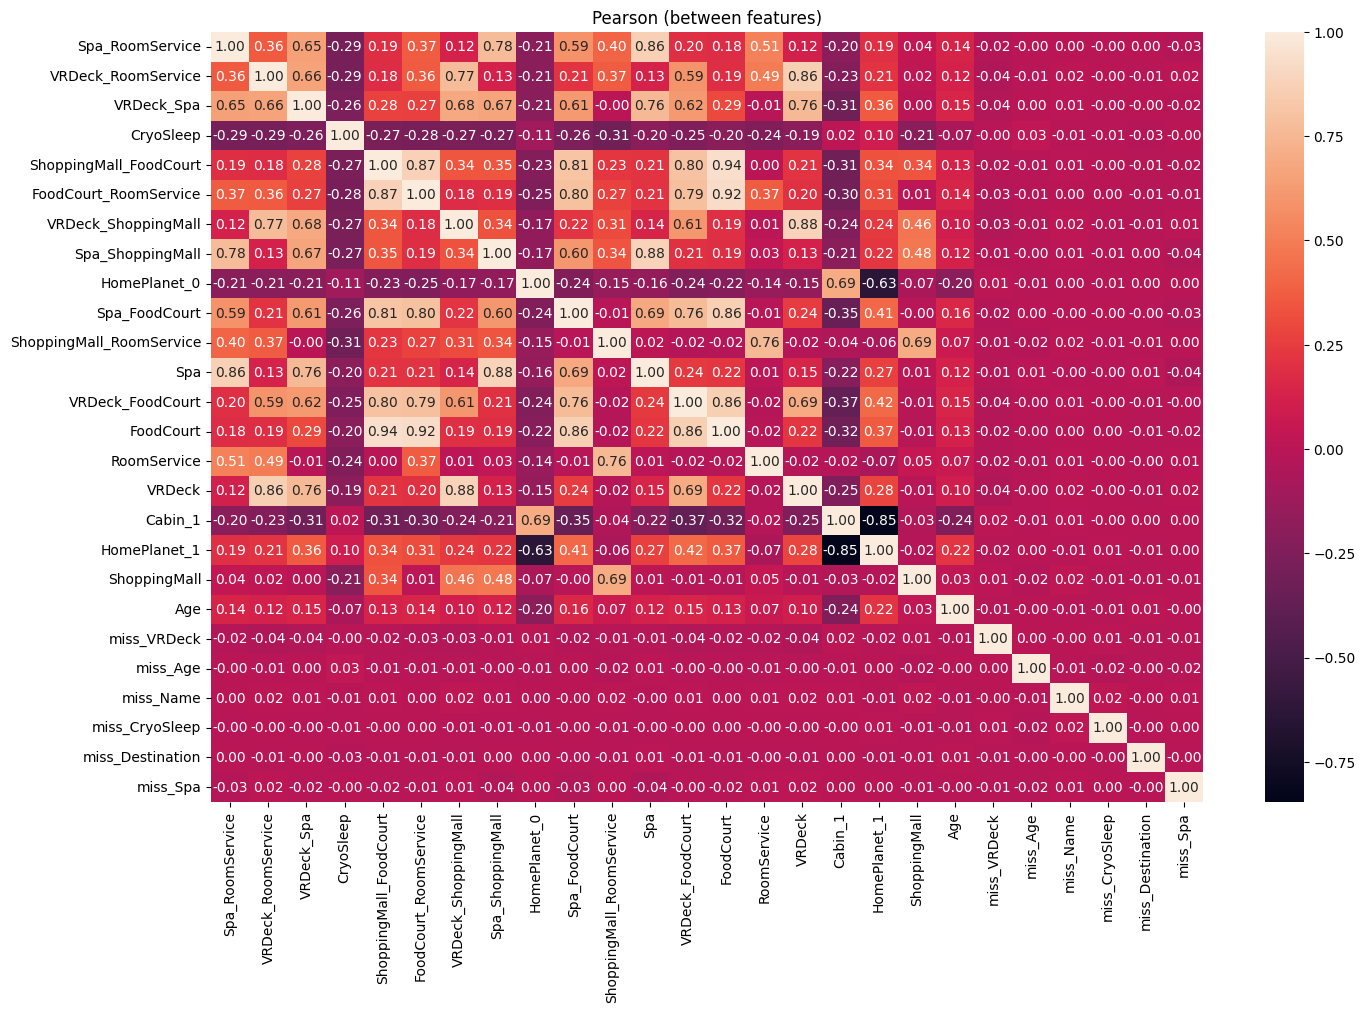

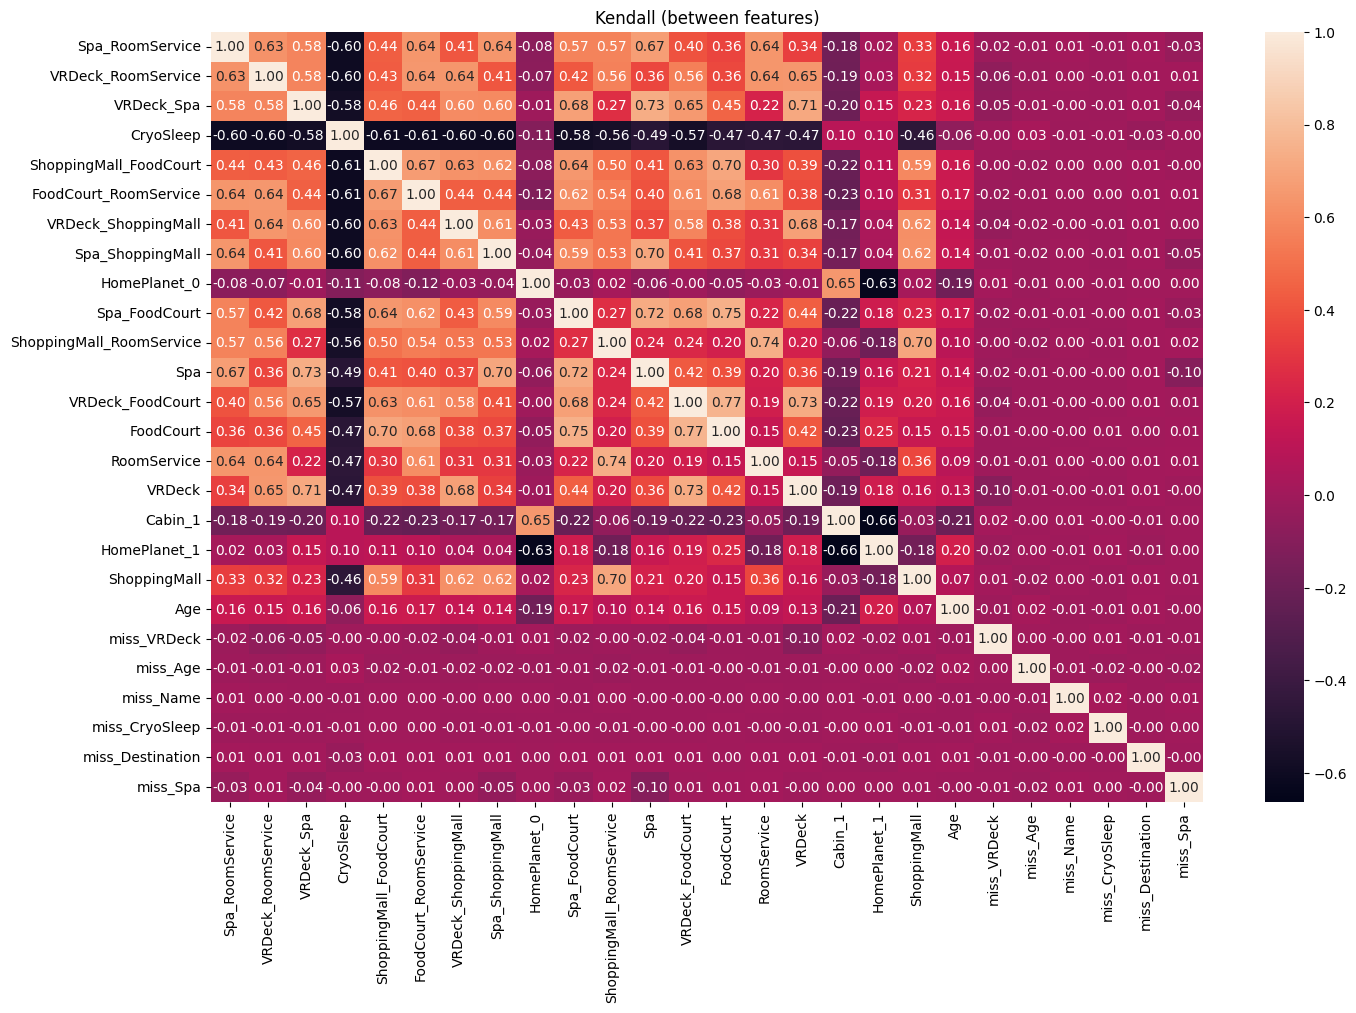

In [94]:
# pearson
plt.figure(figsize=(16,10))
plt.title('Pearson (between features)')
sns.heatmap(pearson, annot=True, fmt='.2f')
plt.show()

# kendall
plt.figure(figsize=(16,10))
plt.title('Kendall (between features)')
sns.heatmap(kendall, annot=True, fmt='.2f')
plt.show()

> **Remove**
>
> Spa_ShoppingMall, Spa, VRDeck_ShoppingMall, VRDeck, FoodCourt_RoomService, Spa_FoodCourt, VRDeck_FoodCourt, FoodCourd

In [95]:
to_remove = ['Spa_ShoppingMall', 'Spa', 'VRDeck_ShoppingMall', 'VRDeck', 'FoodCourt_RoomService', 
                        'Spa_FoodCourt', 'VRDeck_FoodCourt', 'FoodCourt', 'RoomService', 'ShoppingMall']
selected_columns = [x for x in selected_columns if x not in to_remove]
df_train[selected_columns]

,Spa_RoomService,VRDeck_RoomService,VRDeck_Spa,CryoSleep,ShoppingMall_FoodCourt,HomePlanet_0,ShoppingMall_RoomService,Cabin_1,HomePlanet_1,Age,miss_VRDeck,miss_Age,miss_Name,miss_CryoSleep,miss_Destination,miss_Spa
PassengerId,,,,,,,,,,,,,,,,
0001_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,658.0,153.0,593.0,0.0,34.0,1.0,134.0,5.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0
0003_01,6758.0,92.0,6764.0,0.0,3576.0,0.0,43.0,0.0,1.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0
0003_02,3329.0,193.0,3522.0,0.0,1654.0,0.0,371.0,0.0,1.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
0004_01,868.0,305.0,567.0,0.0,221.0,1.0,454.0,5.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,1643.0,74.0,1717.0,0.0,6819.0,0.0,0.0,0.0,1.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0
9278_01,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
9279_01,1.0,0.0,1.0,0.0,1872.0,1.0,1872.0,6.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0


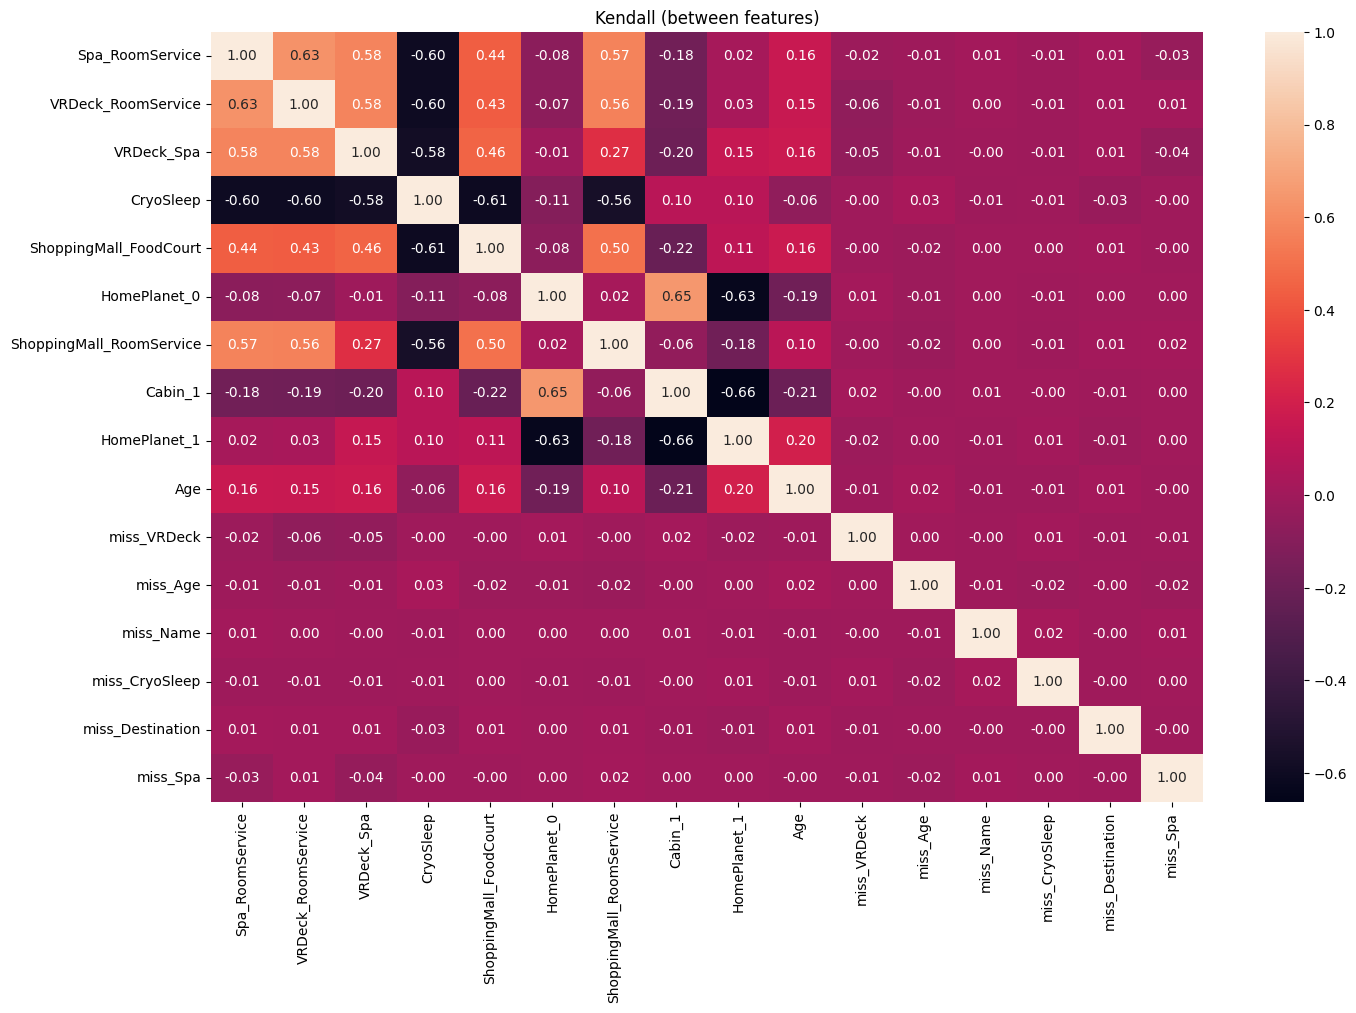

In [96]:
# kendall
kendall = df_train[selected_columns].corr(method='kendall')
plt.figure(figsize=(16,10))
plt.title('Kendall (between features)')
sns.heatmap(kendall, annot=True, fmt='.2f')
plt.show()

## TO DO

- Work more on aggregated features
- Rescale exponential features
- Try begging/stacking models
- TargetEncoding
- Outliers (Age)
- Try handling missing values in other way

## TEST

In [97]:
# TEST
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

# models
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# get df
df = pd.concat((df_train[selected_columns], df_train['Transported']), axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Transported'], axis=1), df['Transported']
                                                    , test_size=0.2)

# rescale data
X_test = (X_test-X_train.min())/(X_train.max()-X_train.min())
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())

In [ ]:
# base model
model = XGBClassifier()
parameters = {
    'max_depth': list(range(2,11)),
    'eta': [0.3, 0.15, 0.075, 0.03, 0.01],
    'gamma': list(range(0, 6)),
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [1, 1.25, 1.5, 1.75, 2],
    'n_estimators': [100,300,500],
    'seed': [0],
}

# hyperparameters search for base model
rs = RandomizedSearchCV(model, parameters, verbose=3, cv=3, n_jobs=-1, n_iter=100)
rs.fit(X_train, y_train)
print('Best parameters found:\n', rs.best_params_)
y_pred = rs.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print('ROC-AUC with RandomSearch:', score)

In [80]:
# begging
base_model = XGBClassifier(reg_alpha=0.25, n_estimators=100, max_depth=10, gamma=4, eta=0.15)
model = BaggingClassifier(base_model, n_estimators=10, max_samples=1.0)
parameters = {
    'estimator': [base_model],
    'n_estimators': [5, 10, 15, 20],
    'max_samples': [0.2, 0.5, 0.8, 1],
}

# hyperparameters search for bagging model
rs = GridSearchCV(model, parameters, verbose=3, cv=3, n_jobs=-1)
rs.fit(X_train, y_train)
print('Best parameters found:\n', rs.best_params_)
y_pred = rs.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print('ROC-AUC with GridSearch:', score)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:
 {'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.15, eval_metric=None,
              feature_types=None, gamma=4, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...), 'max_samples': 0.8, 'n_estimators': 20}
ROC-AUC with GridSearch: 0.8028428991672222


In [99]:
# train model
base_model = XGBClassifier(reg_alpha=0.25, n_estimators=100, max_depth=10, gamma=4, eta=0.15)
model = BaggingClassifier(base_model, n_estimators=20, max_samples=0.8)
model.fit(X_train, y_train)

# evaluate model
print('Single model:')
y_pred = model.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', score)
score = f1_score(y_test, y_pred)
print('F1 score:', score)
score = recall_score(y_test, y_pred)
print('Recall:', score)
score = precision_score(y_test, y_pred)
print('Precision:', score)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')

Single model:
ROC-AUC: 0.7909976480174824
F1 score: 0.7982212340188993
Recall: 0.8177676537585421
Precision: 0.7795874049945711
TP: 718, TN: 658, FP: 203, FN: 160
